In [3]:
import importlib
import warnings
from collections import defaultdict
import altair as alt
from ipywidgets import Video

warnings.filterwarnings('ignore')

def get_data():
    import pandas as pd
    data = []
    mn, mx = float("+inf"), float("-inf")

    for k, arr in loss_tracker.items():
        for i, v in enumerate(arr):
            data.append(dict(model=k, metric='loss', loss=v, epoch=i))
            mn = min(v, mn)
            mx = max(v, mx)
    return pd.DataFrame(data), mn, mx

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import taranis
import torch

loss_tracker = defaultdict(list)

# Machine Learning Primer



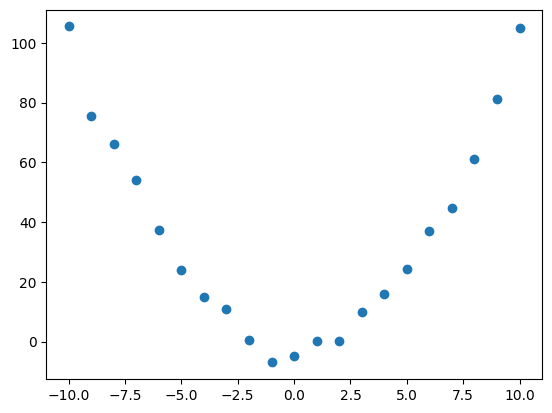

In [6]:
eps = np.random.normal(0, 3, 21)
x = np.asarray(list(range(-10, 11)))
y = x ** 2 + eps

plt.scatter(x, y)

 Linear regression does not work for non linear data

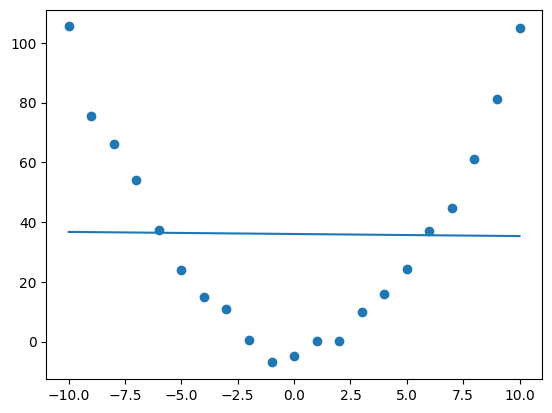

In [7]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x.reshape(-1, 1), y)

a = reg.coef_
b = reg.intercept_

pred = [a * v + b for v in x]
plt.scatter(x, y)
plt.plot(x, pred)

If we know the non linearity we can linearize the relationship
by applying it, the resulting problem becomes linear again

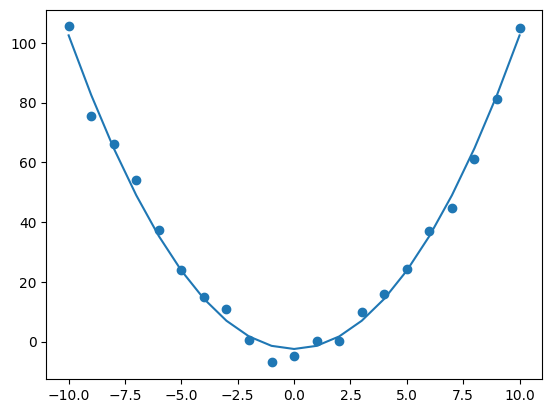

In [8]:
reg = LinearRegression().fit((x ** 2).reshape(-1, 1), y)

a = reg.coef_
b = reg.intercept_

pred = [a * v + b for v in x ** 2]
plt.scatter(x, y)
plt.plot(x, pred)

The problem is: there is an infinity of non linearities and the data can get pretty complex for find non linearity by ourself is not an option. Thankfully Neural Network can approximate any functions and thus learn the non linearity for us.

# Pytorch introduction

## Dataset

In [9]:
from torchvision import datasets
from torchvision import transforms

In [10]:
dataset = datasets.MNIST(
    '../data', 
    train=True, 
    download=True
)
print(len(dataset))

60000


In [11]:
image, label = dataset[0]
print(image.size, label)  # A Black and white image is a 2D matrix (28x28)
image

(28, 28) 5


In [12]:
image, label = dataset[1]
image

In [13]:
image, label = dataset[2]
image

Machine learning is all about creating a function `f` that will learn to approximate a function
For classification we want to approximate a function that will recognize the image it has been given in input

$ f(image) -> class\{ 0-9 \}$

## Linear Regression

## Model definition

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F


n_class = 10


# x                 : N x 28 x 28
# x = Flatten(x)    : N x 728
# x = Linear(x)     : N x 10      = (N x 728) * (728 x 10) + 1 x 10 
# x = Softmax(x)    : N x 10      


linear = nn.Sequential(
    nn.Flatten(),                  # Flatten images from a 2D matrix to 1D => (28x28) => (784,)
    nn.LazyLinear(n_class),        # Simple (a x + b) layer that will learn `a` and `b`
    nn.Softmax(dim=1)              # Normalization so result wil be between [0, 1]
)

In [55]:
# https://www.3blue1brown.com/lessons/neural-networks
Video.from_file("pixels-to-neurons.mp4")

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')

## Prepare Images for the model

In [15]:
image, label = dataset[2]
batch = transforms.ToTensor()(image) # Transform an image to a tensor/matrix

print(image)
print(batch.shape)

<PIL.Image.Image image mode=L size=28x28 at 0x22FFF1BB4C0>
torch.Size([1, 28, 28])


## Make predictions

Of course the model has not been trained yet so the result below are trash.

In [16]:
result = linear(batch)
print('Result:  ', result.shape)

Result:   torch.Size([1, 10])


## Read Predictions

In [17]:
print("\nConfidence of the image to be:")

for v, confidence in enumerate(result.tolist()[0]):
    print(f"  - {v}: {confidence* 100:5.2f}")


prediction = torch.argmax(result)
print('\nPrediction: `', prediction.item(), '` Truth: `', label, '`')


Confidence of the image to be:
  - 0: 12.29
  - 1: 12.54
  - 2:  7.86
  - 3:  9.13
  - 4:  9.10
  - 5:  9.38
  - 6: 15.99
  - 7:  9.08
  - 8:  6.97
  - 9:  7.64

Prediction: ` 6 ` Truth: ` 4 `


# Training

In [18]:
import torch.optim as optim
import torch
import taranis.core.dataset.split as split
from taranis.core.trainer.train import mnist_dataset
from tqdm import tqdm


def newdataloader(batch_size=512):
    # Takes the original dataset and apply transform on the fly
    # Convert image to a tensor
    # normalize the tensor
    dataset_to_use = split.TransformedDatasetClassification(
        dataset, 
        transform=transforms.Compose([                    
            transforms.ToTensor(),                         # Transform the image to tensor
            transforms.Normalize((0.1307,), (0.3081,)),    # Normalize the image
        ])
    )

    # Takes care of spliting the dataset into bite size for our model
    dataloader = torch.utils.data.DataLoader(
        dataset_to_use,
        batch_size = batch_size,
        num_workers = 1,
    )
    
    return dataloader


def train(name, model, epoch=2, lr=0.4):
    batch_size = 512
    dataloader = newdataloader(batch_size)
    
    model = model.cpu()

    # Gradient optimizer 
    optimizer = optim.Adadelta(model.parameters(), lr=lr)
    losses = loss_tracker[name]
    
    with tqdm(total=len(dataset) * epoch, ncols=100) as progress:

        # Repeat a few times 
        for i in range(epoch):
            total_loss = 0
            count = 0

            # Go through the dataset
            for batch, labels in dataloader:
    
                optimizer.zero_grad()                     # Clear previous derivative

                probabilities = model(batch)              # Make prediction

                loss = F.nll_loss(probabilities, labels)  # Grade the prediction 

                loss.backward()                           # Compute derivative

                optimizer.step()                          # Update parameters using derivative

                total_loss += loss.item()                 # Keep track of loss to make sure it goes down

                count += 1
                
                progress.update(batch_size)
            
            loss = total_loss / count
            losses.append(loss)
            progress.set_description(f"loss: {loss:8.4f}")
    
    return losses

NOTE: Redirects are currently not supported in Windows or MacOs.


# Train

In [19]:
train('linear', linear, lr=1, epoch=2)

loss:  -0.8836: : 120832it [00:19, 6068.64it/s]                                                     


[-0.7881446860225524, -0.8836305358652341]

## Prediction

In [20]:
image, label = dataset[2]
batch = transforms.ToTensor()(image)

image

In [21]:
result = linear(batch)
print('Result:  ', result.shape)

print("\nConfidence of the image to be:")

for v, confidence in enumerate(result.tolist()[0]):
    print(f"  - {v}: {confidence* 100:5.2f}")


prediction = torch.argmax(result)
print('\nPrediction', prediction.item(), 'Truth:', label)
image

Result:   torch.Size([1, 10])

Confidence of the image to be:
  - 0:  3.36
  - 1:  0.94
  - 2:  5.38
  - 3: 13.69
  - 4: 51.31
  - 5:  1.02
  - 6:  4.65
  - 7:  1.34
  - 8:  6.61
  - 9: 11.68

Prediction 4 Truth: 4


# Non Linearity

Model is linear only so it can only approximate linear relationships
what is we create more layers ?

In [22]:
deepmodel_bad = nn.Sequential(
    nn.Flatten(),
    nn.LazyLinear(128),    # r1 =  
    nn.LazyLinear(64),     # r2 = (x * a1 + b1) * a2 + b2
    nn.LazyLinear(10),     # r3 = x * w + b
    nn.Softmax(dim=1)      #    w = a1 * a2* a3
                           #    b = b1 * a2* a3 + b2* a3  + b3
)

# r3 = r2 * w3 + b3
# r3 = (r1 * w2 + b2) * w3 + b3
# r3 = r1 * w2 * w3 + b2 * w3  + b3
# r3 = (batch * w1 + b1) * w2 * w3 + b2 * w3  + b3
# r3 = batch * w1 * w2 * w3 + b1 * w2 * w3 + b2 * w3  + b3
#
# r3 = batch * w + b
#  w = w1 * w2 * w3 + b1
#  b =  b1 * w2 * w3 + b2 * w3  + b3
#
#
#   MODEL is still LINEAR
#

batch = transforms.ToTensor()(image)
result = deepmodel_bad(batch)
result.shape

train('deepmodel_bad', deepmodel_bad, lr=1, epoch=2)

loss:  -0.8987: : 120832it [00:19, 6087.84it/s]                                                     


[-0.7872732281684875, -0.8987016996084634]

## Breaking Linearity

In [23]:
#
# Adding non linear function between 
#
deepmodel = nn.Sequential(
    nn.Flatten(),
    nn.LazyLinear(128),    # r1 = batch * w1 + b1
    nn.ReLU(),             # r2 = max(r1, 0)
    nn.LazyLinear(64),     # r3 = r3 * w3 + b3
    nn.ReLU(),             # r4 = max(r3, 0)
    nn.LazyLinear(10),     # r5 = r4 * w4 + b4
    nn.Softmax(dim=1)  
)

#
# Layers cannot be factorized anymore
#
batch = transforms.ToTensor()(image)
result = deepmodel(batch)

# How does training work ?
train('deepmodel', deepmodel, lr=1, epoch=2)

loss:  -0.8993: : 120832it [00:19, 6152.56it/s]                                                     


[-0.6687151974666927, -0.899282231674356]

# Mesuring network's precision

In [24]:
def test_model(model):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    dataset = datasets.MNIST('../data', train=False,  transform=transform)
    
    loader = torch.utils.data.DataLoader(dataset, batch_size=4096, num_workers=1) 
    
    total = len(dataset)
    model = model.cpu()
    
    with torch.no_grad():
        test_loss = 0
        correct = 0
        
        for batch, labels in loader:
            output = model(batch)
            test_loss += F.nll_loss(output, labels, reduction='sum').item()  
            
            pred = output.argmax(dim=1, keepdim=True) 
            correct += pred.eq(labels.view_as(pred)).sum().item()

        print(f'Accuracy {correct / total * 100:.2f} {100 - correct / total * 100:.2f}')

In [25]:
test_model(linear)
test_model(deepmodel_bad)
test_model(deepmodel)

Accuracy 91.04 8.96
Accuracy 89.86 10.14
Accuracy 91.31 8.69


In [26]:
train('linear',        linear       , lr=1  , epoch=5)
train('deepmodel_bad', deepmodel_bad, lr=1  , epoch=5)
train('deepmodel',     deepmodel    , lr=1  , epoch=5)

loss:  -0.9132: : 302080it [00:49, 6056.08it/s]                                                     
loss:  -0.9217: : 302080it [00:50, 6008.12it/s]                                                     
loss:  -0.9577: : 302080it [00:49, 6073.56it/s]                                                     


[-0.6687151974666927,
 -0.899282231674356,
 -0.9230322661036152,
 -0.936245392439729,
 -0.945139322745598,
 -0.9520404076172133,
 -0.957727425179239]

In [27]:
def show_loss_curve():
    data, mn, mx = get_data()
    return (
        alt.Chart(data)
        .mark_line()
        .encode(
            x=alt.X('epoch'), 
            y=alt.Y("loss", scale=alt.Scale(domain=[mn, mx])), 
            color=alt.Color(
                'model', 
                legend=alt.Legend(
                orient='none',
                legendX=130, legendY=-40,
                direction='horizontal',
                titleAnchor='middle')
            )
        )
    )

show_loss_curve()

alt.Chart(...)

In [28]:
test_model(linear)
test_model(deepmodel_bad)
test_model(deepmodel)

Accuracy 92.20 7.80
Accuracy 92.09 7.91
Accuracy 95.81 4.19


Linear model plateau quickly.
Deeper model can learn more but take longer to train.

# Going faster with GPU

In [29]:
from functools import cache

@cache
def newdataloader_cuda(batch_size=512, train=True):
    dataset_to_use = mnist_dataset(train)
    dataset_to_use.tensors = list(dataset_to_use.tensors)
    for i, t in enumerate(dataset_to_use.tensors):
        dataset_to_use.tensors[i] = t.cuda()

    # Takes care of spliting the dataset into bite size for our model
    dataloader = torch.utils.data.DataLoader(
        dataset_to_use,
        batch_size = batch_size,
        num_workers = 0,
    )
    
    return dataloader


def gpu_train(name, original_model, epoch=2, lr=0.4, batch_size=4096):
    dataloader = newdataloader_cuda(batch_size)        # HERE optimized loader
    device = torch.cuda.current_device()               # HERE Get GPU device
    model = original_model.to(device)                  # HERE Convert model to GPU
    
    optimizer = optim.Adadelta(model.parameters(), lr=1)
    losses = loss_tracker[name]
    
    with tqdm(total=len(dataset) * epoch, ncols=100) as progress:
        for i in range(epoch):
            partial_losses = []
            count = 0
            for batch, labels in dataloader:
                batch, labels = batch.to(device), labels.to(device) # HERE: Convert input to GPU

                optimizer.zero_grad()

                probabilities = model(batch)

                loss = F.nll_loss(probabilities, labels)

                loss.backward()

                optimizer.step()

                partial_losses.append(loss.detach())
                count += 1
                
                progress.update(batch_size)

            total_loss = (sum(partial_losses) / count).item()
            losses.append(total_loss)
            progress.set_description(f"loss: {total_loss:8.4f}")
    
    return losses
    
def gpu_test_model(model, batch_size=4096*2):
    dataloader = newdataloader_cuda(batch_size, train=False)     # HERE optimized loader
    total = len(dataloader.dataset)
    
    device = torch.cuda.current_device()  # HERE
    model = model.to(device=device)       # HERE
    
    with torch.no_grad():
        test_loss = 0
        correct = 0
        total_count = 0
        
        for batch, labels in dataloader:
            batch, labels = batch.to(device), labels.to(device) # HERE
            
            output = model(batch)
            test_loss += F.nll_loss(output, labels, reduction='sum').item() 
            
            pred = output.argmax(dim=1, keepdim=True) 
            correct += pred.eq(labels.view_as(pred)).sum().item()
            total_count += batch.shape[0]

        assert total_count == total, f"{total_count} != {total}"
        print('Accuracy', correct / total * 100, 100 - correct / total * 100)

In [30]:
gpu_train('linear'       , linear       , lr=0.5, epoch=5)
gpu_train('deepmodel_bad', deepmodel_bad, lr=0.5, epoch=5)
gpu_train('deepmodel'    , deepmodel    , lr=0.5, epoch=5)

loss:  -0.9177: : 307200it [00:04, 73033.21it/s]                                                    
loss:  -0.9314: : 307200it [00:02, 107051.72it/s]                                                   
loss:  -0.9674: : 307200it [00:03, 101766.52it/s]                                                   


[-0.6687151974666927,
 -0.899282231674356,
 -0.9230322661036152,
 -0.936245392439729,
 -0.945139322745598,
 -0.9520404076172133,
 -0.957727425179239,
 -0.9636276364326477,
 -0.9650025963783264,
 -0.9659247398376465,
 -0.966709315776825,
 -0.9674139618873596]

In [31]:
show_loss_curve()

alt.Chart(...)

In [32]:
gpu_test_model(linear       )
gpu_test_model(deepmodel_bad)
gpu_test_model(deepmodel    )

Accuracy 92.67999999999999 7.320000000000007
Accuracy 92.64 7.359999999999999
Accuracy 96.38 3.6200000000000045


In [33]:
def trainfast(*args, **kwargs):
    if torch.cuda.is_available():
        return gpu_train(*args, **kwargs)
    return train(*args, **kwargs)

def testfast(*args, **kwargs):
    if torch.cuda.is_available():
        return test_model(*args, **kwargs)
    return gpu_test_model(*args, **kwargs)

# Different Layers

Linear layers are quite resource intensive often we will use specialized layer for some specific data.
For example, images will often use convolution layers.

Convolution apply a filter on an image and produce another image https://fr.wikipedia.org/wiki/Noyau_(traitement_d%27image)

In [56]:
Video.from_file("convolution.webm")

Video(value=b'\x1aE\xdf\xa3\x9fB\x86\x81\x01B\xf7\x81\x01B\xf2\x81\x04B\xf3\x81\x08B\x82\x84webmB\x87\x81\x02B…

In [35]:
image, label = dataset[2]
print(image.size, label)  # A Black and white image is a 2D matrix (28x28)
image

(28, 28) 4


In [36]:
conv = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1)
print(conv.weight.shape)

batch = transforms.ToTensor()(image)
print(batch.shape)
result = conv(batch)
print(result.shape)

torch.Size([32, 1, 3, 3])
torch.Size([1, 28, 28])
torch.Size([32, 26, 26])


Example of images generated from a convolution

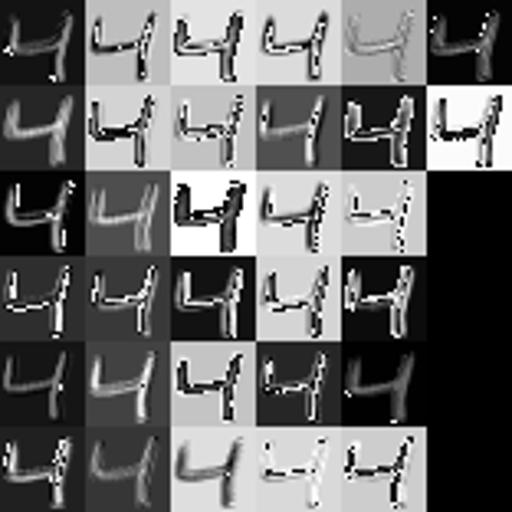

In [37]:
import taranis.core.visualization as viz 
transforms.ToPILImage()(viz.show_conv_layers(result)).resize((512, 512))

# New network with a convolution layer

From a single image it is going to learn to generate 32 new ones to better classify them

In [38]:
from torch.nn import init
from torch import Tensor
import math

import taranis.core.nn as ext_nn
        
conv_model = nn.Sequential(
    # ext_nn.MaskLayer((28, 28)),
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, 3, 1),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(576 * 64, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.Softmax(dim=1),
)

batch = transforms.ToTensor()(image).unsqueeze(0)
batch = torch.concat([batch, batch])
conv_model(batch).shape

torch.Size([2, 10])

## Training

In [39]:
trainfast('conv_model', conv_model, lr=1, epoch=2)
trainfast('conv_model', conv_model, lr=1, epoch=5)
trainfast('conv_model', conv_model, lr=1, epoch=5)
trainfast('conv_model', conv_model, lr=1, epoch=5)
trainfast('conv_model', conv_model, lr=0.5, epoch=5)

loss:  -0.5227: : 122880it [00:48, 2520.05it/s]                                                     
loss:  -0.7368: : 307200it [01:56, 2641.04it/s]                                                     
loss:  -0.7695: : 307200it [01:54, 2676.35it/s]                                                     
loss:  -0.8842: : 307200it [01:56, 2640.89it/s]                                                     
loss:  -0.9670: : 307200it [01:56, 2643.05it/s]                                                     


[-0.25932130217552185,
 -0.5227487683296204,
 -0.6297734379768372,
 -0.6585116386413574,
 -0.6602081656455994,
 -0.6854437589645386,
 -0.7367798089981079,
 -0.7405700087547302,
 -0.7569540143013,
 -0.7608501315116882,
 -0.7672945857048035,
 -0.7695468664169312,
 -0.7708091735839844,
 -0.833173930644989,
 -0.8671407699584961,
 -0.8740515112876892,
 -0.8842071294784546,
 -0.9421319961547852,
 -0.9627605080604553,
 -0.9683816432952881,
 -0.9599688053131104,
 -0.9669569134712219]

## Compare

In [40]:
show_loss_curve()

alt.Chart(...)

In [41]:
testfast(linear)
testfast(deepmodel_bad)
testfast(deepmodel)
testfast(conv_model)

Accuracy 92.68 7.32
Accuracy 92.64 7.36
Accuracy 96.38 3.62
Accuracy 97.23 2.77


## Inspect learned Convolution Kernels

torch.Size([32, 26, 26])


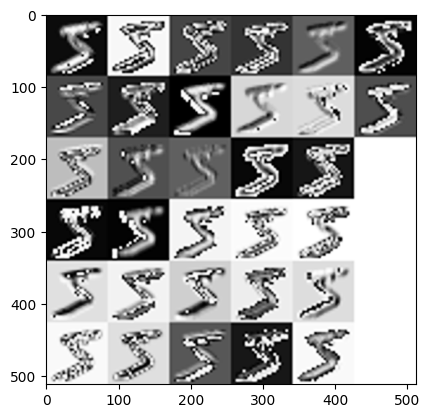

torch.Size([32, 26, 26])


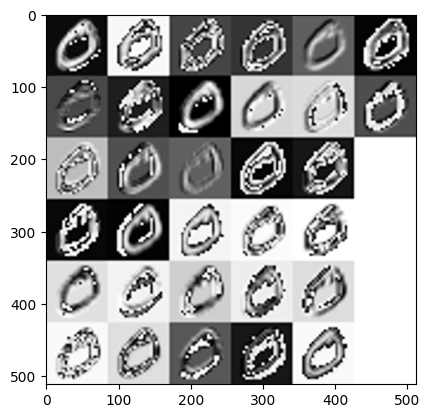

torch.Size([32, 26, 26])


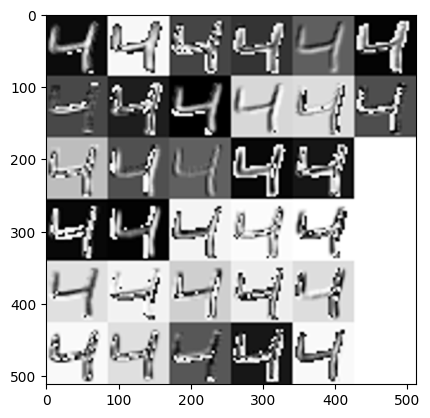

torch.Size([32, 26, 26])


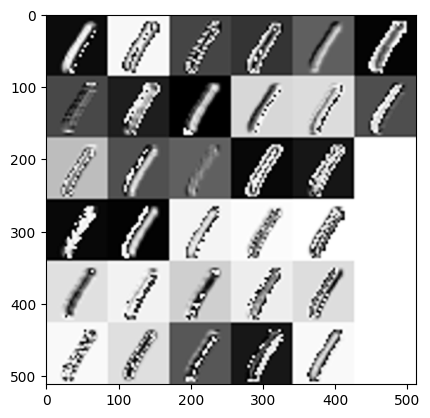

In [42]:
conv_model = conv_model.cpu()

for i in range(4):
    image, label = dataset[i]
    conv = list(conv_model.children())[0]

    batch = transforms.ToTensor()(image)
    result = conv(batch)
    print(result.shape)
    plt.imshow(transforms.ToPILImage()(viz.show_conv_layers(result)).resize((512, 512)), cmap='Greys')
    plt.show()

None torch.Size([1, 1, 28, 28])


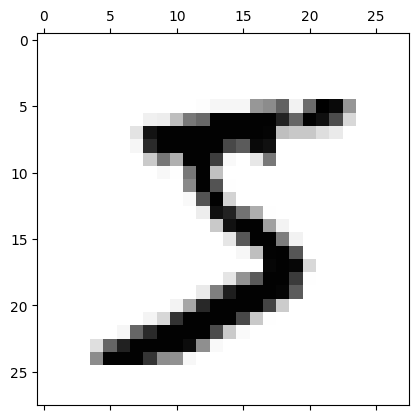

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1)) torch.Size([1, 32, 26, 26])


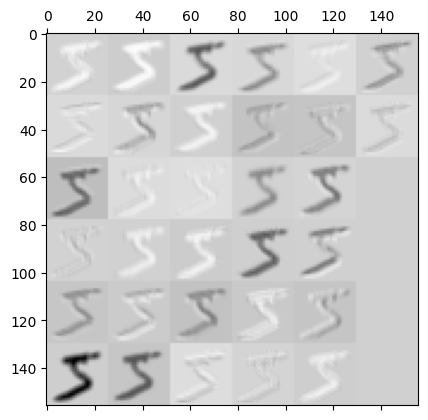

ReLU() torch.Size([1, 32, 26, 26])


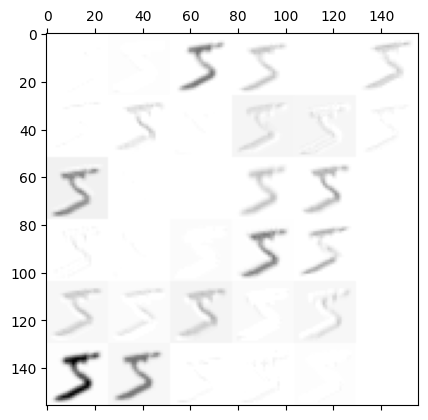

Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)) torch.Size([1, 64, 24, 24])


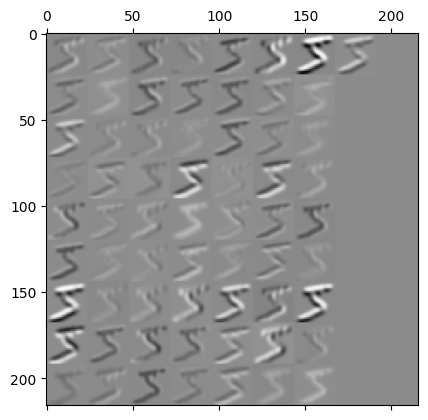

ReLU() torch.Size([1, 64, 24, 24])


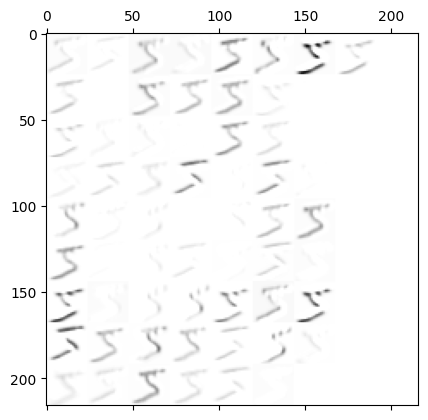

Skip flatten
Linear(in_features=36864, out_features=128, bias=True) torch.Size([1, 128])


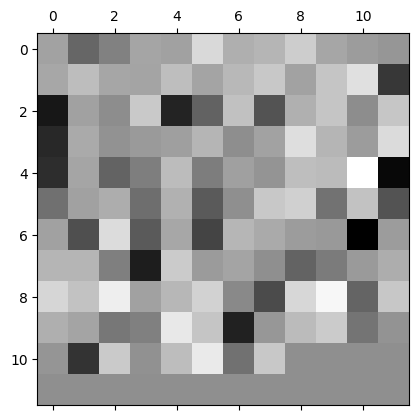

ReLU() torch.Size([1, 128])


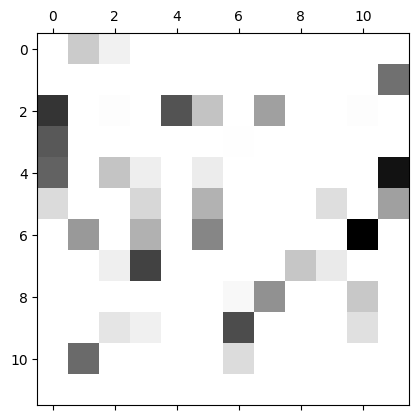

Linear(in_features=128, out_features=10, bias=True) torch.Size([1, 10])


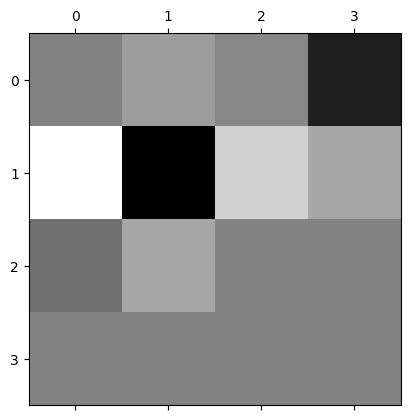

Softmax(dim=1) torch.Size([1, 10])


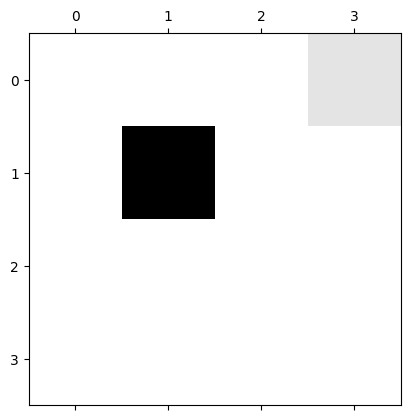

None torch.Size([1, 1, 28, 28])


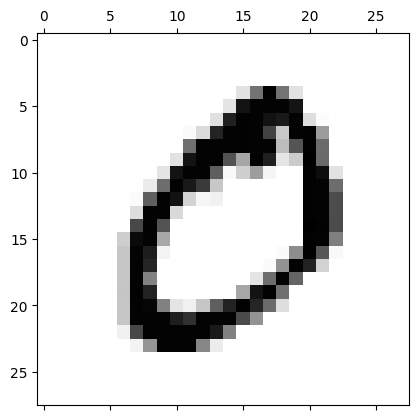

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1)) torch.Size([1, 32, 26, 26])


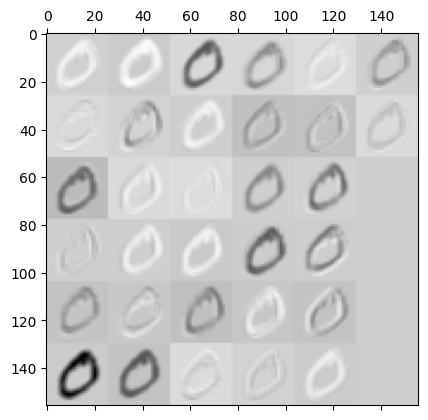

ReLU() torch.Size([1, 32, 26, 26])


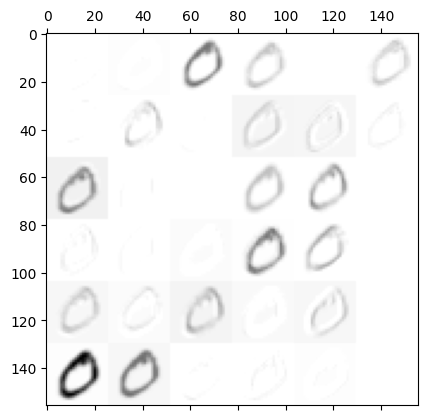

Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)) torch.Size([1, 64, 24, 24])


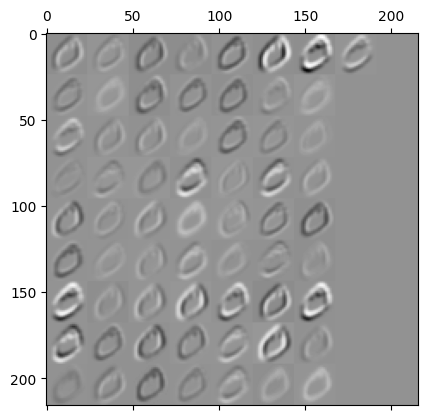

ReLU() torch.Size([1, 64, 24, 24])


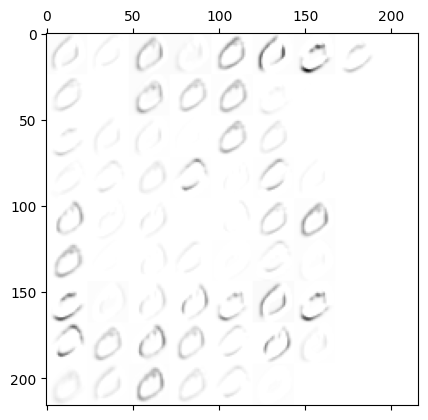

Skip flatten
Linear(in_features=36864, out_features=128, bias=True) torch.Size([1, 128])


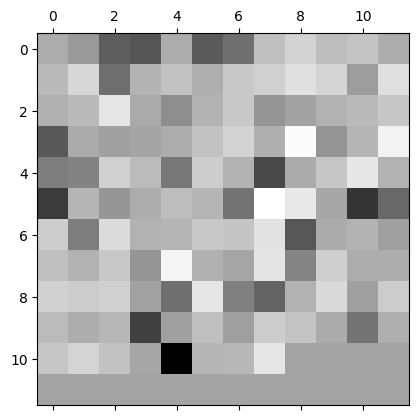

ReLU() torch.Size([1, 128])


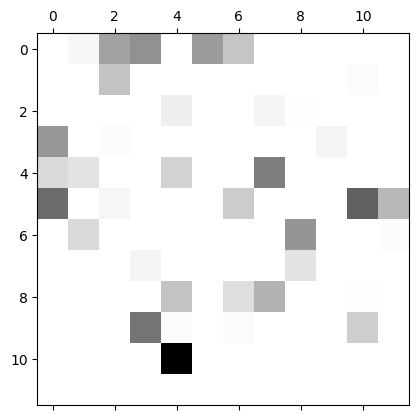

Linear(in_features=128, out_features=10, bias=True) torch.Size([1, 10])


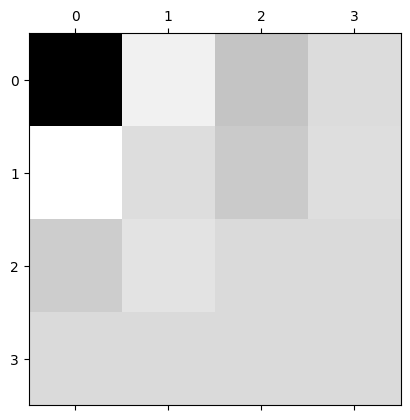

Softmax(dim=1) torch.Size([1, 10])


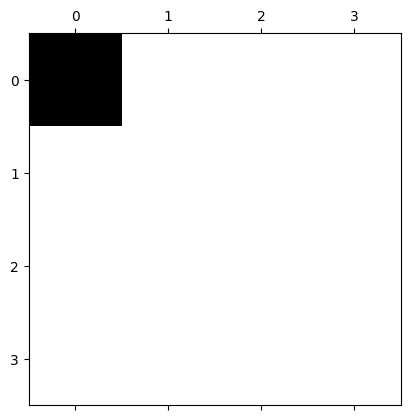

None torch.Size([1, 1, 28, 28])


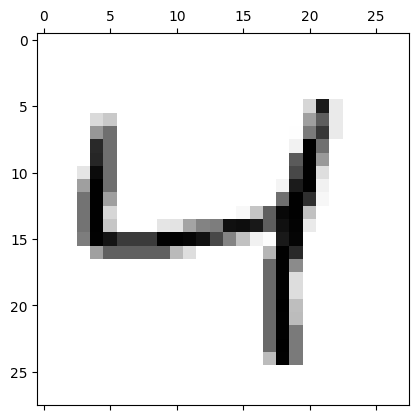

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1)) torch.Size([1, 32, 26, 26])


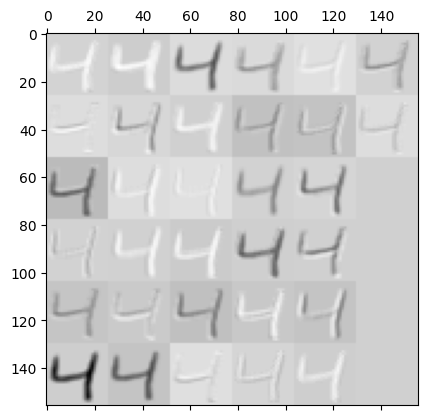

ReLU() torch.Size([1, 32, 26, 26])


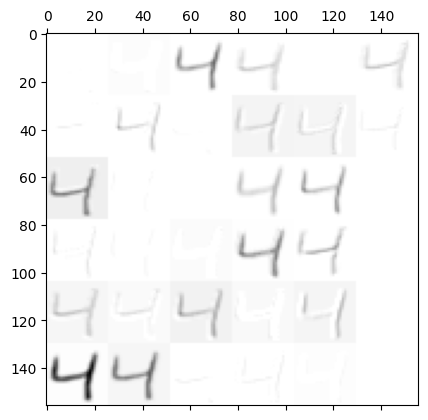

Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)) torch.Size([1, 64, 24, 24])


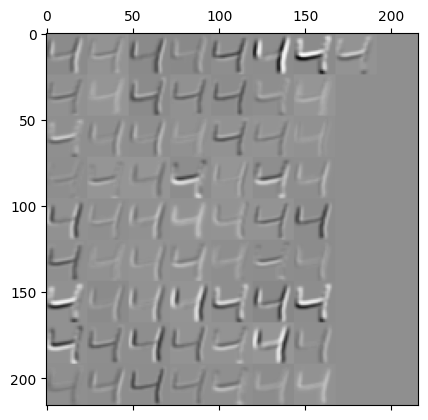

ReLU() torch.Size([1, 64, 24, 24])


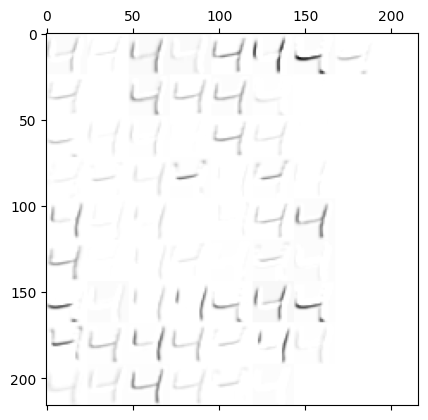

Skip flatten
Linear(in_features=36864, out_features=128, bias=True) torch.Size([1, 128])


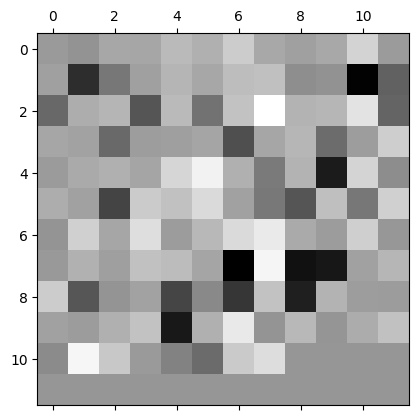

ReLU() torch.Size([1, 128])


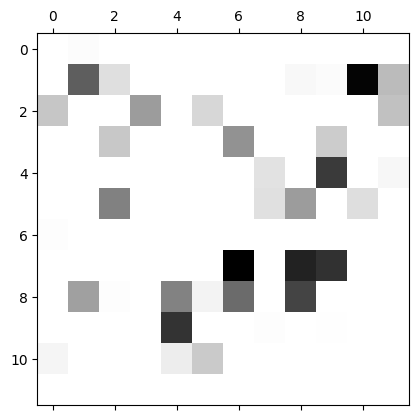

Linear(in_features=128, out_features=10, bias=True) torch.Size([1, 10])


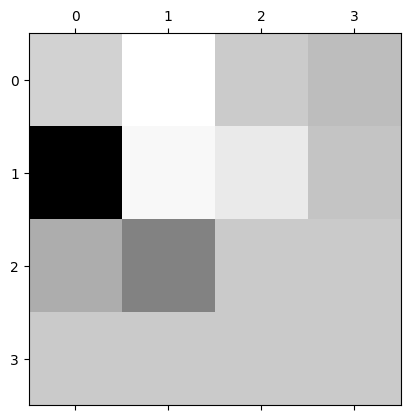

Softmax(dim=1) torch.Size([1, 10])


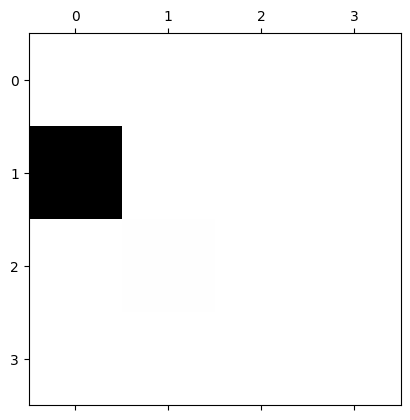

None torch.Size([1, 1, 28, 28])


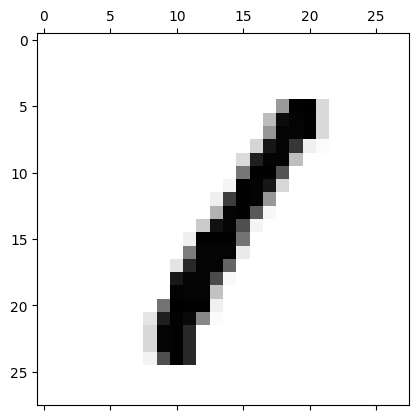

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1)) torch.Size([1, 32, 26, 26])


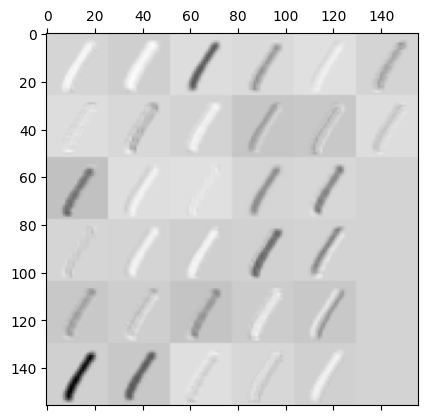

ReLU() torch.Size([1, 32, 26, 26])


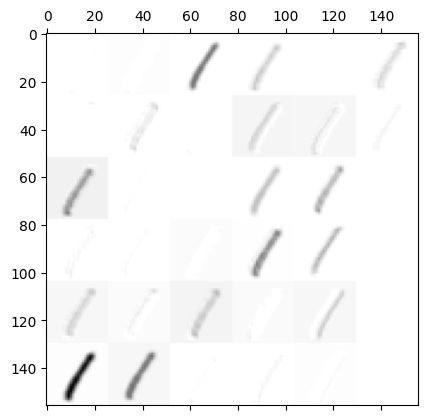

Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)) torch.Size([1, 64, 24, 24])


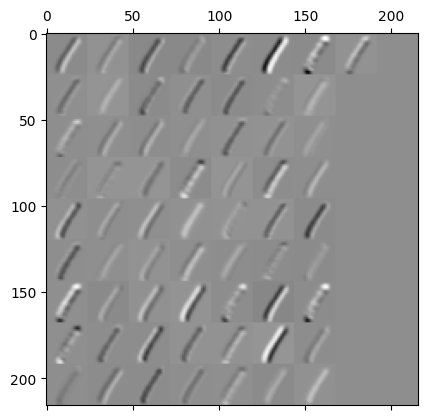

ReLU() torch.Size([1, 64, 24, 24])


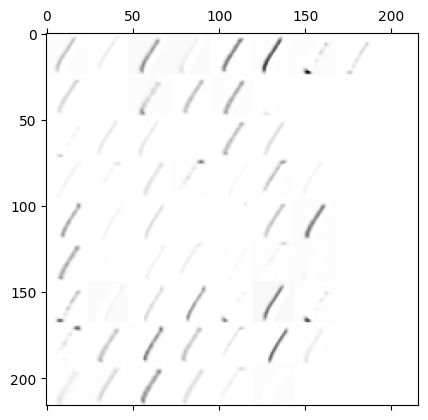

Skip flatten
Linear(in_features=36864, out_features=128, bias=True) torch.Size([1, 128])


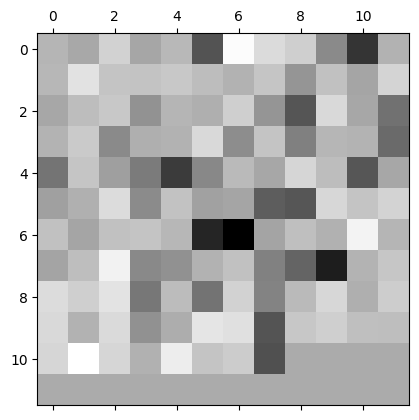

ReLU() torch.Size([1, 128])


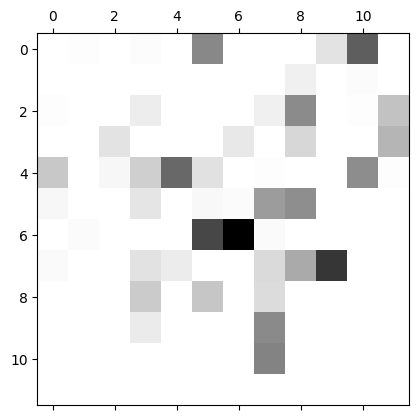

Linear(in_features=128, out_features=10, bias=True) torch.Size([1, 10])


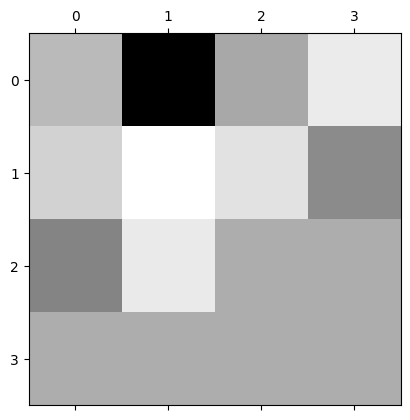

Softmax(dim=1) torch.Size([1, 10])


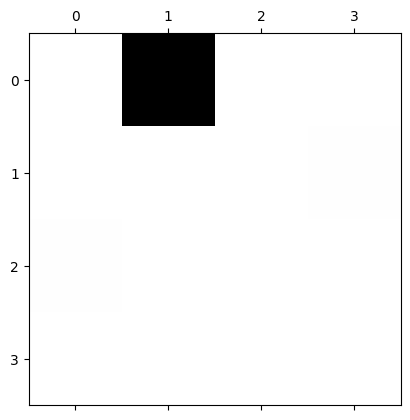

None torch.Size([1, 1, 28, 28])


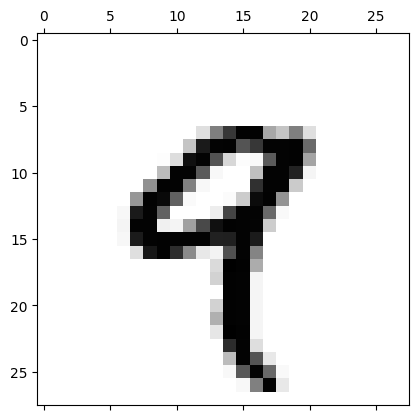

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1)) torch.Size([1, 32, 26, 26])


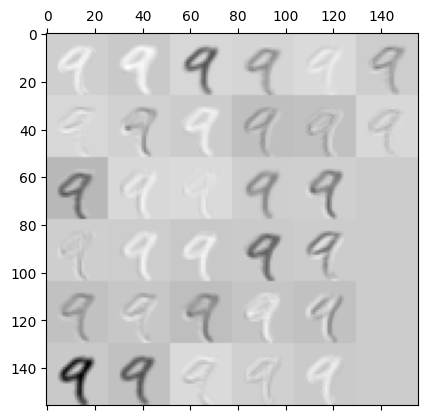

ReLU() torch.Size([1, 32, 26, 26])


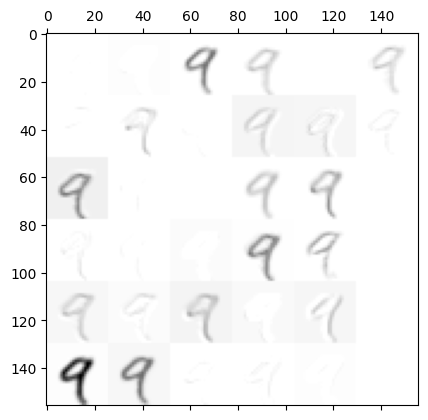

Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)) torch.Size([1, 64, 24, 24])


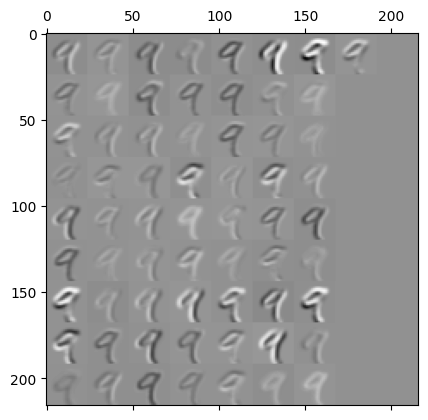

ReLU() torch.Size([1, 64, 24, 24])


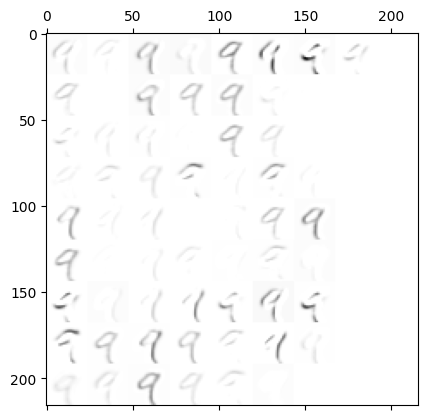

Skip flatten
Linear(in_features=36864, out_features=128, bias=True) torch.Size([1, 128])


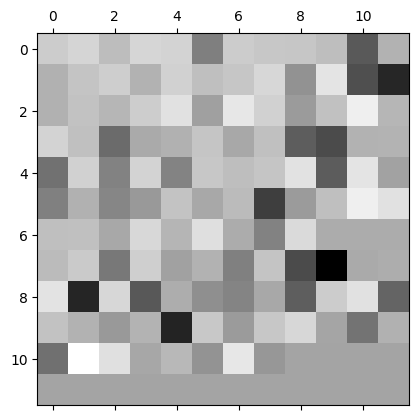

ReLU() torch.Size([1, 128])


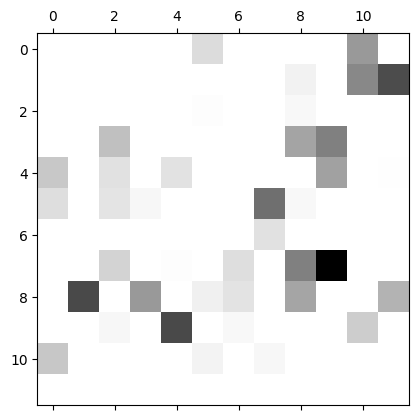

Linear(in_features=128, out_features=10, bias=True) torch.Size([1, 10])


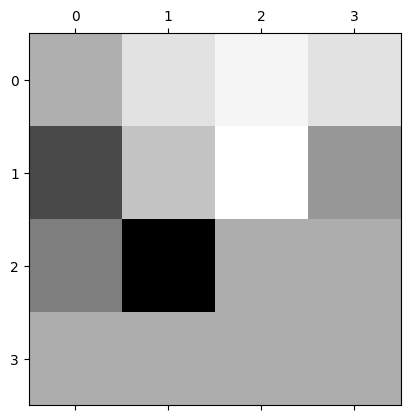

Softmax(dim=1) torch.Size([1, 10])


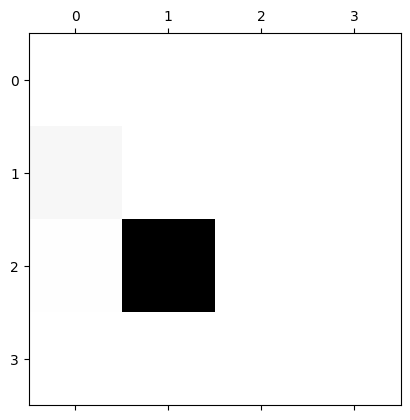

In [43]:
importlib.reload(viz)
viz.show_steps(conv_model, dataset)

# Back to x^2

In [44]:
model = nn.Sequential(
    nn.Linear(1, 2),  
    nn.ReLU(),             
    nn.Linear(2, 1), 
)

list(model.parameters())

[Parameter containing:
 tensor([[0.4450],
         [0.8181]], requires_grad=True),
 Parameter containing:
 tensor([-0.8214, -0.7667], requires_grad=True),
 Parameter containing:
 tensor([[-0.4674, -0.4787]], requires_grad=True),
 Parameter containing:
 tensor([0.1568], requires_grad=True)]

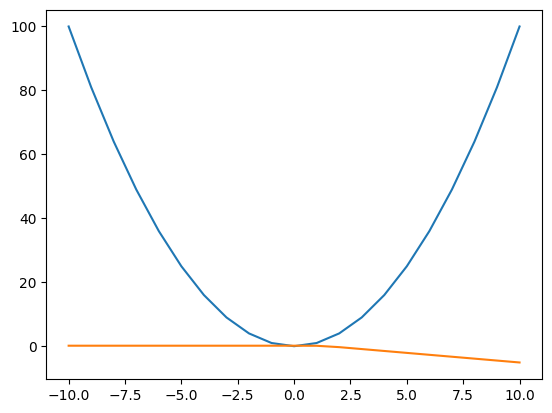

In [45]:
x = np.asarray(list(range(-10, 11)))
y = x ** 2

input = torch.tensor(x, dtype=torch.float).unsqueeze(1)
output = torch.tensor(y, dtype=torch.float).unsqueeze(1)
pred = model(input).detach().numpy()

plt.plot(x, y)
plt.plot(x, pred)

In [46]:
def train_reg(model, epoch=100):
    optimizer = optim.Adadelta(model.parameters(), lr=1)

    for i in range(epoch):
        optimizer.zero_grad()
        pred = model(input)
        loss = F.mse_loss(pred, output)
        loss.backward()
        optimizer.step()

        if i % (epoch / 10) == 0:
            print(loss.item())
            
train_reg(model, 2000)

2550.544921875
2307.69384765625
1231.1146240234375
1178.0045166015625
1086.4141845703125
1045.023681640625
996.6417236328125
953.184814453125
914.0120239257812
880.1407470703125


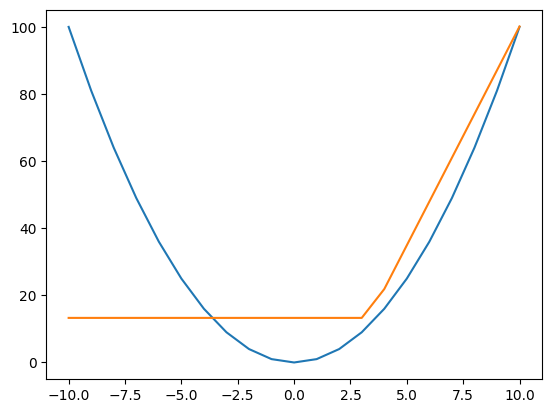

In [47]:
pred = model(input).detach().numpy()
plt.plot(x, y)
plt.plot(x, pred)

# Increase number of neurons

2476.3623046875
75.24893951416016
37.964019775390625
31.803449630737305
25.3197078704834
21.567306518554688
18.611892700195312
15.8767728805542
13.923925399780273
12.589008331298828


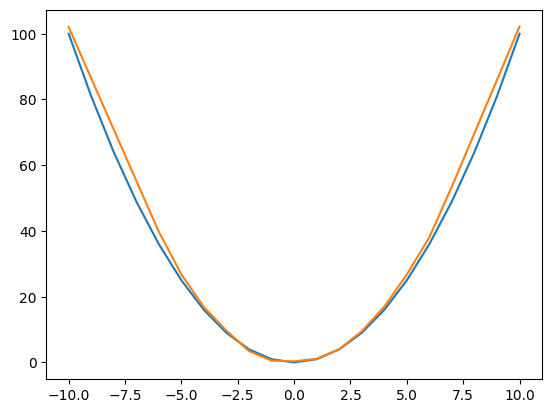

In [48]:
model = nn.Sequential(
    nn.Linear(1, 128),  
    nn.ReLU(),             
    nn.Linear(128, 1), 
)
train_reg(model, 2000)
pred = model(input).detach().numpy()
plt.plot(x, y)
plt.plot(x, pred)

# Non Linear correlation

In [49]:
# Regular linear Correlation does not work well shows x, y are essentially not correlated
print(np.corrcoef(x, y))

[[ 1.00000000e+00 -2.73542223e-17]
 [-2.73542223e-17  1.00000000e+00]]


In [50]:
pred = model(input).detach().squeeze().numpy()

#
# Correlation is essentially one
#
print(np.corrcoef(pred, y))

[[1.         0.99883264]
 [0.99883264 1.        ]]


# Generalization

Current models are not able to learn or infer outside of the training set
if we increase the domain of the function from $[-10, 10]$ we can see that the error will keep increasing.

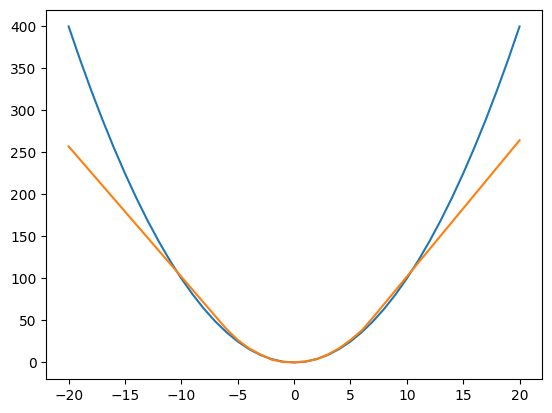

In [51]:
x = np.asarray(list(range(-20, 21)))
y = x ** 2

input = torch.tensor(x, dtype=torch.float).unsqueeze(1)
pred = model(input).detach().numpy()
plt.plot(x, y)
plt.plot(x, pred)

# With sin the issue is more obvious

0.9888454675674438
0.02056996338069439
0.015062004327774048
0.011298397555947304
0.00858382973819971
0.00680546136572957
0.005526883061975241
0.004650662653148174
0.0039960844442248344
0.003562173806130886


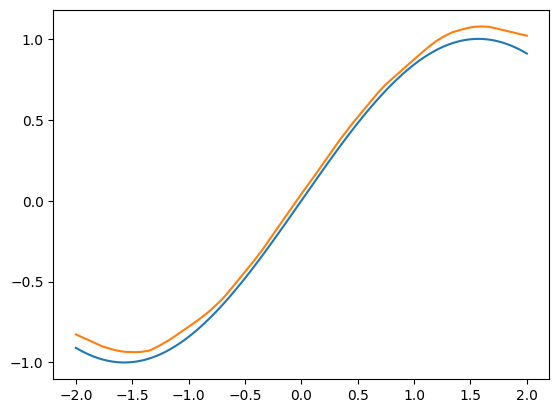

In [52]:
x = np.asarray(list(range(-100, 101))) / 50
y = np.sin(x)

input = torch.tensor(x, dtype=torch.float).unsqueeze(1)
output = torch.tensor(y, dtype=torch.float).unsqueeze(1)

model = nn.Sequential(
    nn.Linear(1, 128),  
    nn.ReLU(),             
    nn.Linear(128, 1), 
)

train_reg(model, 2000)
pred = model(input).detach().numpy()
plt.plot(x, y)
plt.plot(x, pred)

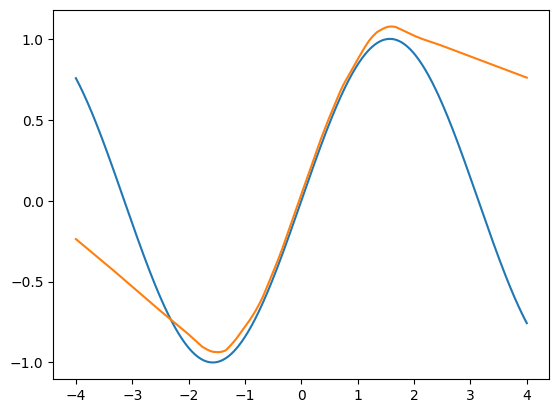

In [53]:
x = np.asarray(list(range(-200, 201))) / 50
y = np.sin(x)

input = torch.tensor(x, dtype=torch.float).unsqueeze(1)
pred = model(input).detach().numpy()
plt.plot(x, y)
plt.plot(x, pred)

0.5526729822158813
0.12905754148960114
0.07913447171449661
0.0532592348754406
0.03896847739815712
0.03087264858186245
0.026710836216807365
0.02444509230554104
0.023675117641687393
0.024202559143304825


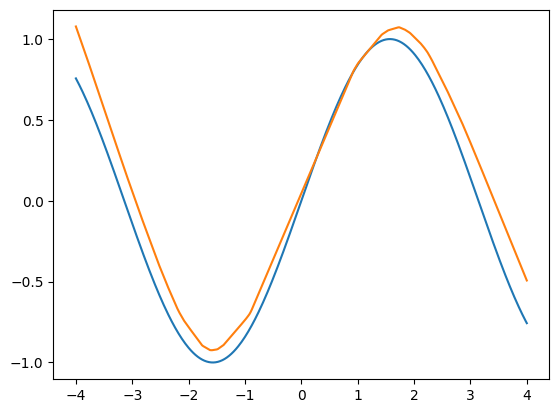

In [54]:
x = np.asarray(list(range(-200, 201))) / 50
y = np.sin(x)

input = torch.tensor(x, dtype=torch.float).unsqueeze(1)
output = torch.tensor(y, dtype=torch.float).unsqueeze(1)

model = nn.Sequential(
    nn.Linear(1, 256),  
    nn.ReLU(),             
    nn.Linear(256, 1), 
)

train_reg(model, 2000)
pred = model(input).detach().numpy()
plt.plot(x, y)
plt.plot(x, pred)